# Python Weekly Project Night

## Translating MATLAB code for gradient descent solution for simple regression into python

First, the necessary libraries are imported

1. math (for functions such as fabs, ceil, log2, etc.)
2. numpy (for ndarray and associated functions)
3. matplotlib.pyplot (for plotting the theta and cost function values across iterations)

In [1]:
# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt

Next, a brief function is defined which can replace
sum() or numpy.sum() for relatively short
single-column arrays (< 1000 elements!).

In [2]:
# JIT summing function (faster for short! ndarray[m])
from numba import jit
@jit('f8(f8[:])', nopython=True)
def jit_array_sum(column_array):
    '''
    jit_array_sum computes the sum over a one-dimensional
    column_array, which means the input must be of shape (m,)
    '''
    s = np.float64(0.0)
    for idx in range(column_array.size):
        s += column_array[idx]
    return s

Then, the function is defined that computes the
cost of the regression.

In [3]:
# define function that computes regression error
def rcost(theta, x, y):
    """
    rcost computes the cost function for the regression
    linear regression error e = y - x * theta, such that
    cost = (1 / (2 * m)) * sum(e ** 2)
    with m being the length of e (number of samples).
    
    input parameters:
        theta   - weights for the columns in x
        x       - design matrix
        y       - observed output
    """
        
    # compute prediction
    p = np.matmul(x, theta)
    
    # compute error
    e = (y - p)
    
    # compute cost
    return (1 / (2 * e.size)) * jit_array_sum(np.multiply(e, e))


Next, the function to compute the gradient of a
function w.r.t. the theta parameters is defined.

In [4]:
# define function that computes gradient
def fgrad(fun, theta, *args):
    """
    fgrad computes the gradient of function fun with respect
    to the parameters theta, using additional arguments.
    
    theta must be a ndarray with single indexing
    """
    
    # create theta copy for manipulation
    theta_copy = theta.copy()
    
    # create copy for gradients
    theta_grads = theta.copy()
    
    # loop over theta parameters
    for ti in range(theta.size):
        
        # compute steps for gradient based on magnitude
        m = max(-20., math.ceil(math.log2(math.fabs(theta[ti]) + 2.3e-16)) - 10.)
        g = math.pow(2., m)
        theta_copy[ti] = theta[ti] - g
        cost_down = fun(theta_copy, x, y)
        theta_copy[ti] = theta[ti] + g
        cost_up = fun(theta_copy, x, y)
        theta_copy[ti] = theta[ti]
        
        # compute gradient
        theta_grads[ti] = (cost_up - cost_down) / (2 * g)
        
    # return gradient
    return theta_grads


And finally, the function performing gradient descent is defined

In [5]:
# define function that searches gradient
def gdesc(fun, theta, x, y, learning_rate = 0.1, maxiter = 500):
    
    # create theta_copy
    theta_copy = theta.copy()
    
    # compute initial cost
    cost0 = fun(theta, x, y)
    
    # stopping criterion
    stopc = 1.0e-15
    
    # values over time
    theta_vals = np.empty((maxiter, theta.size))
    cost_vals = np.empty((maxiter, 1))
    theta_vals[:] = np.nan
    cost_vals[:] = np.nan
    
    # iterate
    iter = 0;
    while iter < maxiter:
        
        # store values
        theta_vals[iter, :] = theta_copy[:]
        cost_vals[iter] = cost0

        # compute gradients
        theta_grads = fgrad(fun, theta_copy, x, y)
        
        # update theta based on learning rate
        for ti in range(theta.size):
            theta_copy[ti] = theta_copy[ti] - learning_rate * theta_grads[ti]
        
        # compute new cost
        cost = fun(theta_copy, x, y)
        
        # if difference smaller criterion
        if math.fabs(cost0 - cost) < stopc:
            break
        
        # update cost
        cost0 = cost
        iter = iter + 1
    
    # store last value?
    if iter < maxiter:
        theta_vals[iter, :] = theta_copy.reshape((1, theta_copy.size))
        cost_vals[iter] = cost

    # return theta_copy and theta_vals
    return (theta_copy, theta_vals, cost_vals)
    

The example uses theta initialized to (0, 0),
and a design matrix with a constant (all-1) column,
and a column of random numbers. The output variable,
y, is assigned a combination of these, plus additional
random noise.

In [6]:
# assign some values
t = np.zeros(2,)
x = np.empty([50, 2])
x[:, 0] = 1
x[:, 1] = np.random.randn(50)
y = (np.random.rand(1,) + np.random.rand(1,) * x[:, 1]) + np.random.randn(50)

Then the function is tested, and the final_t (theta) values are printed out.

In [7]:
# find thetas
final_t, t_vals, c_vals = gdesc(rcost, t, x, y)

# print final_t
print(final_t)

[0.30579535 0.12956253]


And the theta and cost function values across iterations can be easily plotted.

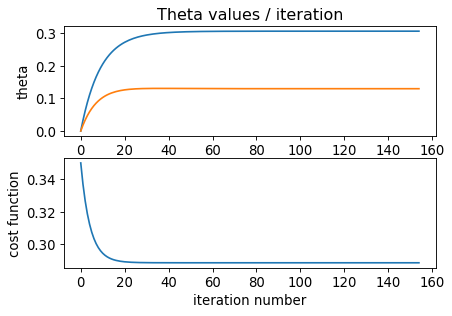

In [8]:
# set some plotting parameters (font size)
plt.rcParams.update({'font.size': 12})

# start a figure
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

# plot (with two sub-plots)
plt.subplot(2, 1, 1)
plt.plot(t_vals)
plt.title('Theta values / iteration')
plt.ylabel('theta')

plt.subplot(2, 1, 2)
plt.plot(c_vals)
plt.xlabel('iteration number')
plt.ylabel('cost function')
plt.show()

Here, a function is defined that performs the steps
above so that they can be called with a single line.

In [9]:
# define a function that does everything
def test_gradient_descent(numiter=1000):
    
    # loop
    for liter in range(numiter):
        
        # assign some values
        t = np.zeros(2,)
        x = np.empty([50, 2])
        x[:, 0] = 1
        x[:, 1] = np.random.randn(50)
        y = (np.random.rand(1,) + np.random.rand(1,) * x[:, 1]) + np.random.randn(50)
    
        # run function
        final_t, t_vals, c_vals = gdesc(rcost, t, x, y)

And we can measure the (average) time it takes for the function to complete

In [10]:
# time it
import timeit

timeit.timeit(test_gradient_descent, number=1)

7.263578317

Or profile it, which prints much more information
as to which calls are the most "expensive" ones:

In [11]:
# profiling
import cProfile
cProfile.run('test_gradient_descent()')


         8539047 function calls in 11.046 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1470835    0.515    0.000    0.515    0.000 <ipython-input-2-28b92ddc224b>:3(jit_array_sum)
  1470835    4.754    0.000    6.694    0.000 <ipython-input-3-dc4ad545d749>:2(rcost)
   293967    2.377    0.000    8.518    0.000 <ipython-input-4-94a0f2499bb7>:2(fgrad)
     1000    1.134    0.001   11.018    0.011 <ipython-input-5-c23b3f97cafb>:2(gdesc)
        1    0.016    0.016   11.046   11.046 <ipython-input-9-632cdf7d7ad9>:2(test_gradient_descent)
        1    0.000    0.000   11.046   11.046 <string>:1(<module>)
        1    0.000    0.000   11.046   11.046 {built-in method builtins.exec}
   587934    0.156    0.000    0.156    0.000 {built-in method builtins.max}
   587934    0.117    0.000    0.117    0.000 {built-in method math.ceil}
   881901    0.112    0.000    0.112    0.000 {built-in method math.fabs}
   587934    0.091    0

Comparing the different summing functions

In [12]:
# possibly redefine y
y = np.random.randn(1000,)
%timeit sum(y)

87.5 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
%timeit np.sum(y)

3.77 µs ± 86.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
%timeit jit_array_sum(y)

1.1 µs ± 8.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
